# Multiple sequence alignment and tree building

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/imperial-genomics-facility/viral-genome-notebook-image/master?urlpath=lab%2Ftree%2Fexamples%2Fcoronavirus_analysis_multiple_sequence_alignment_and_tree_building.ipynb)

* __Notebook version__: `v0.0.1`
* __Created by:__ [Dr. Hiren Ghosh](https://www.linkedin.com/in/hiren-ghosh-phd-6181853a), `Imperial BRC Genomics Facility`
* __Maintained by:__ `Imperial BRC Genomics Facility`
* __Docker image:__ [imperialgenomicsfacility/viral-genome-analysis-notebooks](https://hub.docker.com/r/imperialgenomicsfacility/viral-genome-analysis-notebooks)
* __Github repository:__ [imperial-genomics-facility/viral-genome-notebook-image](https://github.com/imperial-genomics-facility/viral-genome-notebook-image)
* __Created on:__ `2020-April-21 14:42`
* __Contact us:__ [Imperial BRC Genomics Facility](https://www.imperial.ac.uk/medicine/research-and-impact/facilities/genomics-facility/contact/)
* __License:__ [Apache License 2.0](https://github.com/imperial-genomics-facility/scanpy-notebook-image/blob/master/LICENSE)

## Data fetching

__List of genomes__:

* [__NC_045512.2__](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2): Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
* [__MN988668.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN988668.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV WHU01, complete genome
* [__MN938384.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN938384.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV_HKU-SZ-002a_2020, complete genome
* [__MN975262.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN975262.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV_HKU-SZ-005b_2020, complete genome
* [__MN985325.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN985325.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-WA1/2020, complete genome
* [__MN988713.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN988713.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-IL1/2020, complete genome
* [__MN994467.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN994467.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-CA1/2020, complete genome
* [__MN994468.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN994468.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-CA2/2020, complete genome
* [__MN997409.1__](https://www.ncbi.nlm.nih.gov/nuccore/MN997409.1): Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-AZ1/2020, complete genome

In [1]:
import os
import requests
import json
import time
from ete3 import Tree, TreeStyle,SeqMotifFace
os.environ['QT_QPA_PLATFORM']='offscreen'

In [2]:
def fetch_genome_fasta_from_ncbi(refseq_id,output_path='.',file_format='fasta'):
  '''
  A function for fetching the genome fasta sequences from NCBI
  
  :param refseq_id: NCBI genome id
  :param output_path: Path to dump genome files, default '.'
  :param file_format: Output fileformat, default fasta, supported formats are 'fasta' and 'gb'
  :return: output_file
  '''
  try:
    url = \
      'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id={0}&rettype={1}'.\
        format(refseq_id,file_format)
    r = requests.get(url)
    if r.status_code != 200:
      raise ValueError(
              'Failed to download data from NCBI for id {0}, error code: {1}'.\
                format(refseq_id,r.status_code))
    fasta_data = r.content.decode('utf-8')
    output_file = \
      os.path.join(
        os.path.abspath(output_path),
        '{0}.{1}'.format(refseq_id,file_format))
    with open(output_file,'w') as fp:
      fp.write(fasta_data)
    print('Downloaded genome seq for {0}'.format(refseq_id))
    return output_file
  except Exception as e:
    print('Failed to download data for {0} from NCBI, error: {1}'.format(refseq_id,e))

In [3]:
genome_list = [
    'MN988668.1',
    'NC_045512.2',
    'MN938384.1',
    'MN975262.1',
    'MN985325.1',
    'MN988713.1',
    'MN994467.1',
    'MN994468.1',
    'MN997409.1'
]

In [5]:
fasta_list = []
for id in genome_list:
  fasta_list.\
    append(
      fetch_genome_fasta_from_ncbi(
        refseq_id=id,
        output_path='/tmp'))
  time.sleep(2)
fasta_list

Downloaded genome seq for MN988668.1
Downloaded genome seq for NC_045512.2
Downloaded genome seq for MN938384.1
Downloaded genome seq for MN975262.1
Downloaded genome seq for MN985325.1
Downloaded genome seq for MN988713.1
Downloaded genome seq for MN994467.1
Downloaded genome seq for MN994468.1
Downloaded genome seq for MN997409.1


['/tmp/MN988668.1.fasta',
 '/tmp/NC_045512.2.fasta',
 '/tmp/MN938384.1.fasta',
 '/tmp/MN975262.1.fasta',
 '/tmp/MN985325.1.fasta',
 '/tmp/MN988713.1.fasta',
 '/tmp/MN994467.1.fasta',
 '/tmp/MN994468.1.fasta',
 '/tmp/MN997409.1.fasta']

## Multiple sequence alignment with Muscle

Merge all fasta files to a single filne and create multiple sequence alignment

In [6]:
MERGED_FASTA = '/tmp/corona_merged.fasta'
!rm -f $MERGED_FASTA
for f in fasta_list:
  !cat $f >> $MERGED_FASTA

## count the genome sequences in the merged fasta file
!grep '>' $MERGED_FASTA|wc -l

9


In [9]:
%%time

MUSCLE_MSA = '/tmp/corona_merged.afa'
!muscle -in $MERGED_FASTA -maxiters 2 -out $MUSCLE_MSA


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

corona_merged 9 seqs, lengths min 29838, max 29903, avg 29880
00:00:00     20 MB(2%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00     20 MB(2%)  Iter   1  100.00%  K-mer dist pass 2
00:02:27  1126 MB(100%)  Iter   1  100.00%  Align node      
00:02:27  1126 MB(100%)  Iter   1  100.00%  Root alignment
00:03:58  1126 MB(100%)  Iter   2  100.00%  Refine tree   
00:03:58  1126 MB(100%)  Iter   2  100.00%  Root alignment
00:03:58  1126 MB(100%)  Iter   2  100.00%  Root alignment
CPU times: user 5.8 s, sys: 1.41 s, total: 7.21 s
Wall time: 3min 58s


## Tree building using FastTree

Build phylogenetic tree with FastTree

In [10]:
%%time

TREE_FILE = '/tmp/corona_merged.tree'
!FastTree -nt -gtr < $MUSCLE_MSA > $TREE_FILE

FastTree Version 2.1.10 Double precision (No SSE3)
Alignment: standard input
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Generalized Time-Reversible, CAT approximation with 20 rate categories
Ignored unknown character S (seen 1 times)
Ignored unknown character W (seen 1 times)
Ignored unknown character Y (seen 6 times)
Initial topology in 0.05 seconds
Refining topology: 13 rounds ME-NNIs, 2 rounds ME-SPRs, 6 rounds ML-NNIs
Total branch-length 0.001 after 0.50 sec, 1 of 7 splits   

WARNING! This alignment consists of closely-related and very-long sequences.
WARNING! FastTree (or other standard maximum-likelihood tools)
may not be appropriate for aligments of very closely-related sequences
like this one, as FastTree does not account for recombination or gene conversion

ML-NNI round 1: LogLk = -41615.807 NNIs 2 max delta 0.00 Time 0.85
GTR

## Plotting trees

In [11]:
t = Tree(TREE_FILE)

In [12]:
## ascii tree
print(t)


   /-MN938384.1
  |
  |--MN997409.1
--|
  |   /-MN975262.1
  |  |
   \-|   /-MN985325.1
     |  |
     |  |      /-MN988713.1
      \-|   /-|
        |  |  |   /-MN994468.1
        |  |   \-|
         \-|     |   /-NC_045512.2
           |      \-|
           |         \-MN988668.1
           |
            \-MN994467.1


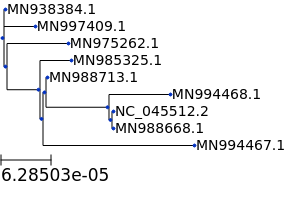

In [13]:
## plain tree
t.render("%%inline")

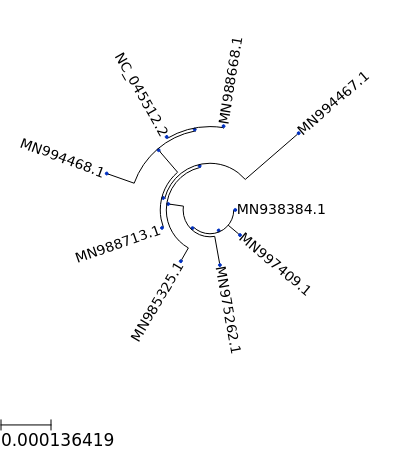

In [14]:
## circular tree
ts = TreeStyle()
ts.mode = "c"
t.render("%%inline",  tree_style=ts)

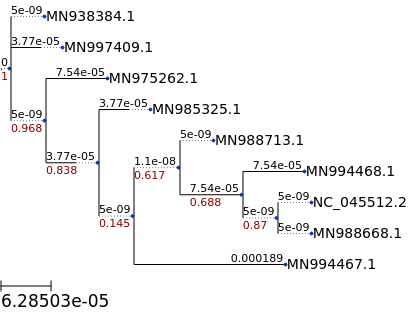

In [15]:
## tree with branch length
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
t.render("%%inline", tree_style=ts)

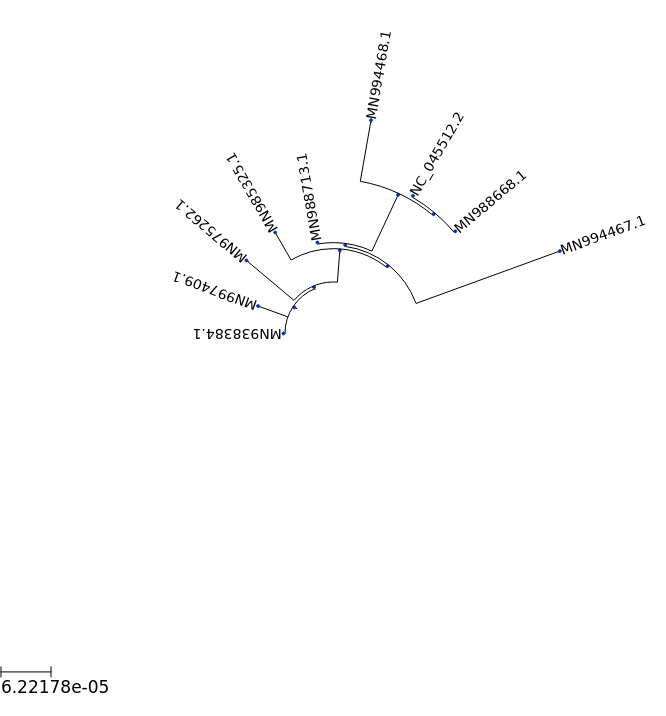

In [16]:
## 180 deg circular tree
ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
t.render("%%inline", tree_style=ts)

In [18]:
## read aligned fastq file
fasta_data = dict()
with open(MUSCLE_MSA,'r') as fp:
    header = ''
    fasta_list = list()
    for line in fp:
        line = line.strip()
        if line.startswith('>'):
            if header != '':
                fasta_data.update({header:''.join(fasta_list)})
            header = line.split()[0].replace('>','')
            fasta_list = list()
        else:
            fasta_list.append(line)
    
    fasta_data.update({header:''.join(fasta_list)})

In [19]:
## tree with aligned seq
for seq_id,seq in fasta_data.items():
    seqFace = SeqMotifFace(seq, gapcolor="red")
    (t & "{0}".format(seq_id)).add_face(seqFace, 0, "aligned")
ts = TreeStyle()
ts.tree_width = 100
t.render("tree_with_aln.png", tree_style=ts);
## check png using image viewer

## Referenc

* Edgar, R.C. MUSCLE: a multiple sequence alignment method with reduced time and space complexity. BMC Bioinformatics 5, 113 (2004). https://doi.org/10.1186/1471-2105-5-113
* Price, M.N., Dehal, P.S., and Arkin, A.P. (2009) FastTree: Computing Large Minimum-Evolution Trees with Profiles instead of a Distance Matrix. Molecular Biology and Evolution 26:1641-1650, doi:10.1093/molbev/msp077.
* Price, M.N., Dehal, P.S., and Arkin, A.P. (2010) FastTree 2 -- Approximately Maximum-Likelihood Trees for Large Alignments. PLoS ONE, 5(3):e9490. doi:10.1371/journal.pone.0009490.
* ETE 3: Reconstruction, analysis and visualization of phylogenomic data.
Jaime Huerta-Cepas, Francois Serra and Peer Bork. Mol Biol Evol 2016; doi: 10.1093/molbev/msw046